# Análise do consumo de cerveja:
## Escopo:
- jovens
- região universitária de São Paulo - SP
## Feature Importance:
- Teoria da Informação
- PCA
## Modelos Preditivos: 
- Random Forest
- XGBoost
- Bayesian Network

## Bibliotecas

In [74]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx


## Funções auxiliares

In [75]:
def feature_importance_analysis(df, target_column):
    # Selecionar as variáveis independentes (features) e a variável dependente (target)
    X = df.drop(columns=[target_column, 'date'])  # Excluir a coluna 'date'
    
    # Manter apenas as colunas numéricas
    X = X.select_dtypes(include=['float64', 'int64'])
    
    y = df[target_column]

    # Calcular a importância das características usando ganho de informação (mutual information)
    feature_importances = mutual_info_regression(X, y, random_state=42)
    feature_names = X.columns

    # Criar um DataFrame para exibir a importância das características
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    return importance_df

In [76]:
def plot_feature_importance(importance_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Importância das Características')
    plt.xlabel('Importância')
    plt.ylabel('Características')
    plt.tight_layout()
    plt.show()

In [77]:
def plot_scree_plot(pca):
    plt.figure(figsize=(10, 6))
    
    # Gráfico de linha para a variância explicada cumulativa
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_.cumsum(), 
             marker='o', linestyle='--', color='b')
    
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [78]:
def plot_feature_importance(importance_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', dodge=False, palette='viridis', legend=False)
    plt.title('Importância das Características')
    plt.xlabel('Importância')
    plt.ylabel('Características')
    plt.tight_layout()
    plt.show()



In [79]:
def plot_accuracy(model, X_test, y_test, y_pred):
    # Gráfico de Dispersão
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previstos')
    plt.title('Gráfico de Dispersão: Valores Reais vs. Valores Previstos')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    # Curva de Aprendizado
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_test, y_test, train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error', cv=5
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.subplot(1, 2, 2)
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Erro no Treinamento')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Erro no Teste')
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('Erro Quadrático Médio (MSE)')
    plt.title('Curva de Aprendizado')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

In [80]:
def plot_error_distribution(y_test, y_pred):
    # Histograma dos Erros
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Erro')
    plt.ylabel('Frequência')
    plt.title('Distribuição dos Erros')
    plt.show()

In [81]:
def pca_analysis(df, target_column):
    # Selecionar as variáveis independentes (features) e a variável dependente (target)

    columns_to_drop = [target_column]
    columns_to_drop.append('consumption_categ')
    columns_to_drop.append('max_temp_categ')
    if 'date' in df.columns:
        columns_to_drop.append('date')
    if 'holiday_name' in df.columns:
        columns_to_drop.append('holiday_name')

    X = df.drop(columns=columns_to_drop)
    y = df[target_column]
    
    y = df[target_column]

    # Padronizar os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Aplicar PCA
    pca = PCA(n_components=len(X.columns))
    X_pca = pca.fit_transform(X_scaled)

    # Obter a importância das características
    feature_importances = pca.explained_variance_ratio_
    feature_names = X.columns

    # Criar um DataFrame para exibir a importância das características
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    return importance_df, pca

In [82]:
def plot_pca_importance(importance_df, pca):
    plt.figure(figsize=(10, 6))
    
    # Gráfico de barras para a importância de cada componente principal
    plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Variance Explained Ratio')
    plt.title('Feature Importance based on PCA')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [83]:
def train_gradient_boosting(df):
    # Definir variáveis independentes (X) e dependente (y)
    X = df.drop(columns=['beer_consumption_liters'])
    y = df['beer_consumption_liters']

    # Dividir os dados em conjunto de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar e treinar o modelo de Gradient Boosting
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Avaliar o modelo
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    return model, X_train.columns

In [84]:
def ttrain_random_forest(df):
    # Definir variáveis independentes (X) e dependente (y)
    X = df.drop(columns=['beer_consumption_liters', 'date'])
    y = df['beer_consumption_liters']

    # Dividir os dados em conjunto de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar e treinar o modelo de Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Avaliar o modelo
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    # Retornar o modelo treinado e as colunas de características usadas no treinamento
    return model, X_train.columns

In [85]:
def predict_beer_consumption_xg(model, feature_columns, new_data):
    new_data = new_data.reindex(columns=feature_columns, fill_value=0)
    predicted_consumption = model.predict(new_data)
    return predicted_consumption

## Amostra de Dados (Consumo, Período, Clima, Feriados, Jogos de Futebol)

In [87]:
# Carregar o arquivo CSV
df = pd.read_csv('data/data.csv', sep=';')
df.head()

,date,avg_temperature_c,min_temperature_c,max_temperature_c,precipitation_mm,weekend,beer_consumption_liters,holiday_name,is_holiday,has_match,...,is_gremio,is_atletico_mineiro,is_bahia,is_internacional,is_city_match,month,week_day,is_rain,consumption_categ,max_temp_categ
0,2015-01-01,27.30,23.9,32.5,0.0,0.0,25461.0,Confraternização Universal,1,0,...,0,0,0,0,0,1,3,0,25001-30000,30-35
1,2015-01-02,27.02,24.5,33.5,0.0,0.0,28972.0,NaN,0,0,...,0,0,0,0,0,1,4,0,25001-30000,30-35
2,2015-01-03,24.82,22.4,29.9,0.0,1.0,30814.0,NaN,0,0,...,0,0,0,0,0,1,5,0,>30000,25-30
3,2015-01-04,23.98,21.5,28.6,1.2,1.0,29799.0,NaN,0,0,...,0,0,0,0,0,1,6,1,25001-30000,25-30
4,2015-01-05,23.82,21.0,28.3,0.0,0.0,289.0,NaN,0,0,...,0,0,0,0,0,1,0,0,0-5000,25-30


## Feature Importance (Teoria da Informação)

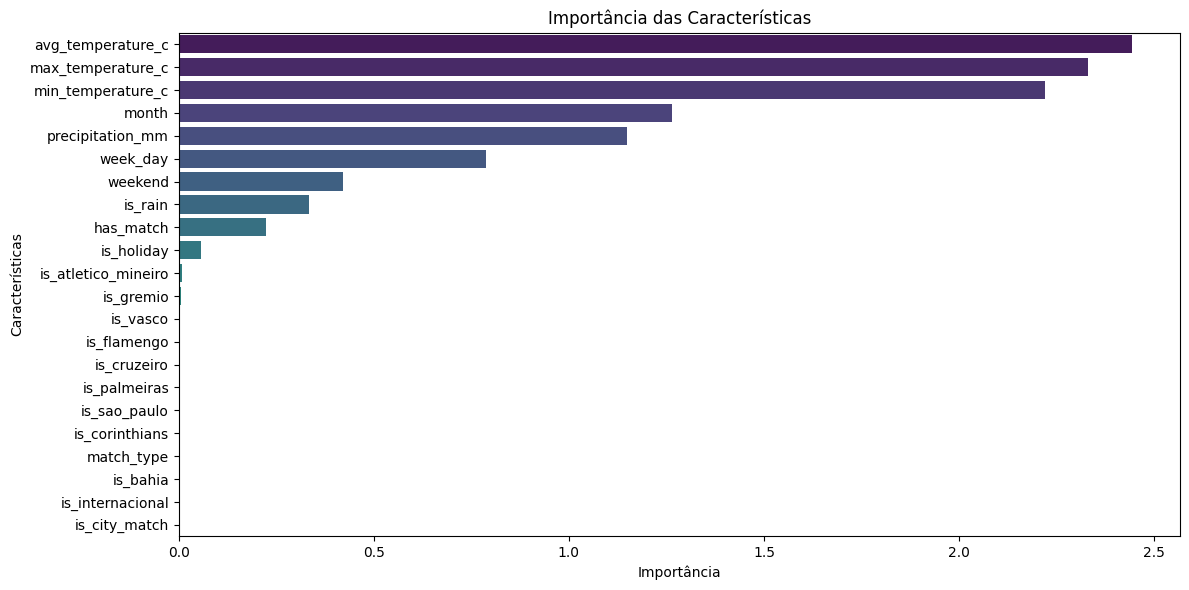

In [88]:
# Garantir que colunas categóricas sejam convertidas para numéricas
df = pd.get_dummies(df, columns=['holiday_name'], drop_first=True)

# Executar a análise de importância de características
importance_df = feature_importance_analysis(df, 'beer_consumption_liters')
plot_feature_importance(importance_df)

## Feature Importance (PCA)

In [89]:
importance_df, pca = pca_analysis(df, 'beer_consumption_liters')
importance_df

,Feature,Importance
0,avg_temperature_c,1.094107e-01
1,min_temperature_c,8.006348e-02
2,max_temperature_c,6.543326e-02
3,precipitation_mm,5.565134e-02
4,weekend,5.088968e-02
5,is_holiday,4.005222e-02
6,has_match,3.717211e-02
7,match_type,3.507014e-02
8,is_flamengo,3.453374e-02
9,is_corinthians,3.370026e-02


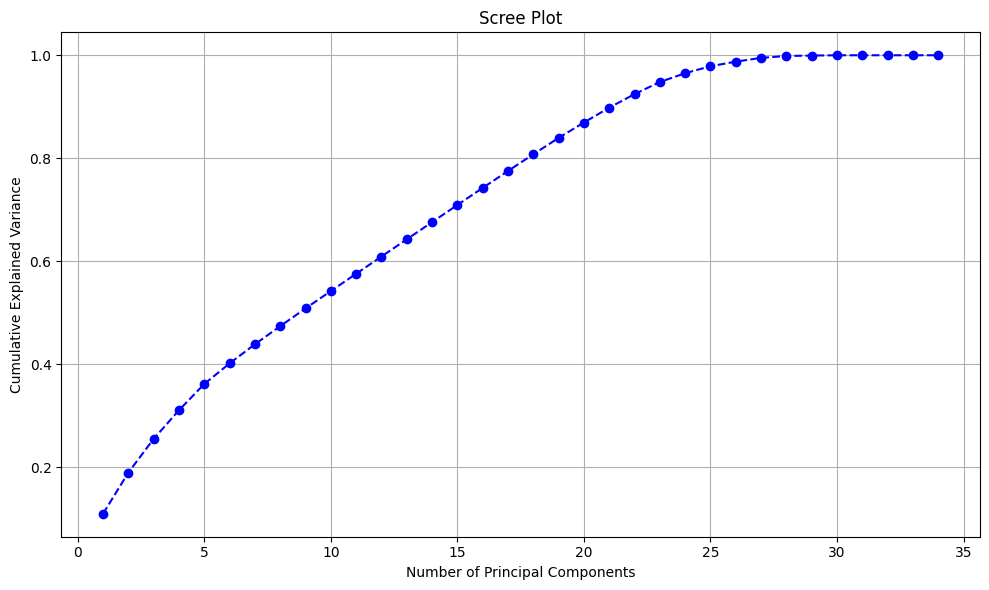

In [90]:

plot_scree_plot(pca)

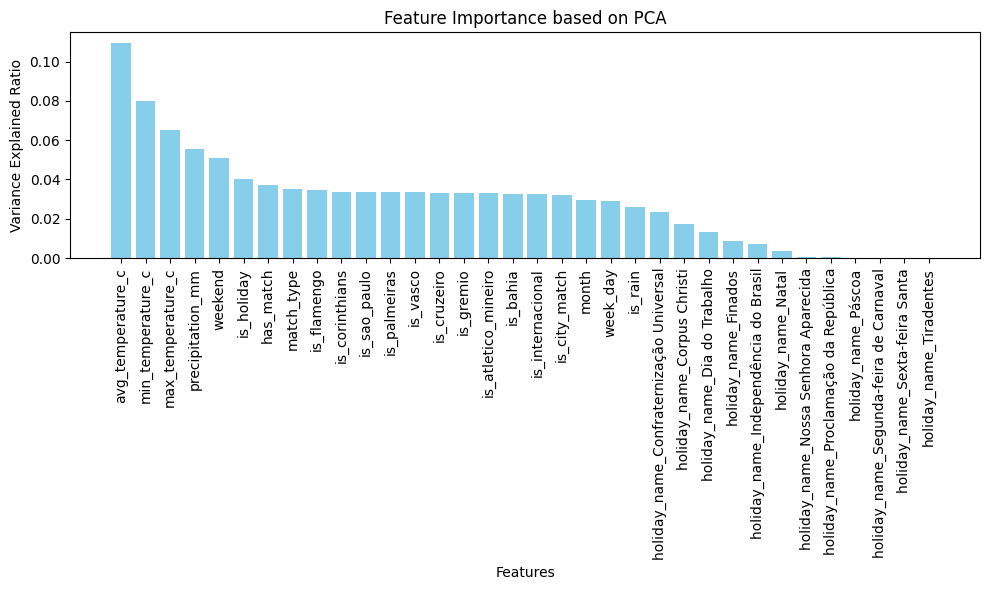

In [91]:
# Chamar a função para criar o gráfico de barras
plot_pca_importance(importance_df, pca)

## Treinamento do modelo de Random Forest

In [92]:
df = df.drop(columns=['consumption_categ', 'max_temp_categ'])

rf_model, rf_feature_columns = ttrain_random_forest(df)

# Fazer previsões no conjunto de teste
X = df.drop(columns=['beer_consumption_liters'])
y = df['beer_consumption_liters']

X = df.drop(columns=['beer_consumption_liters', 'date'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_rf_pred = rf_model.predict(X_test)



Mean Squared Error: 28069447.831891663


## Acurácia e distribuição dos erros para o modelo Random Forest

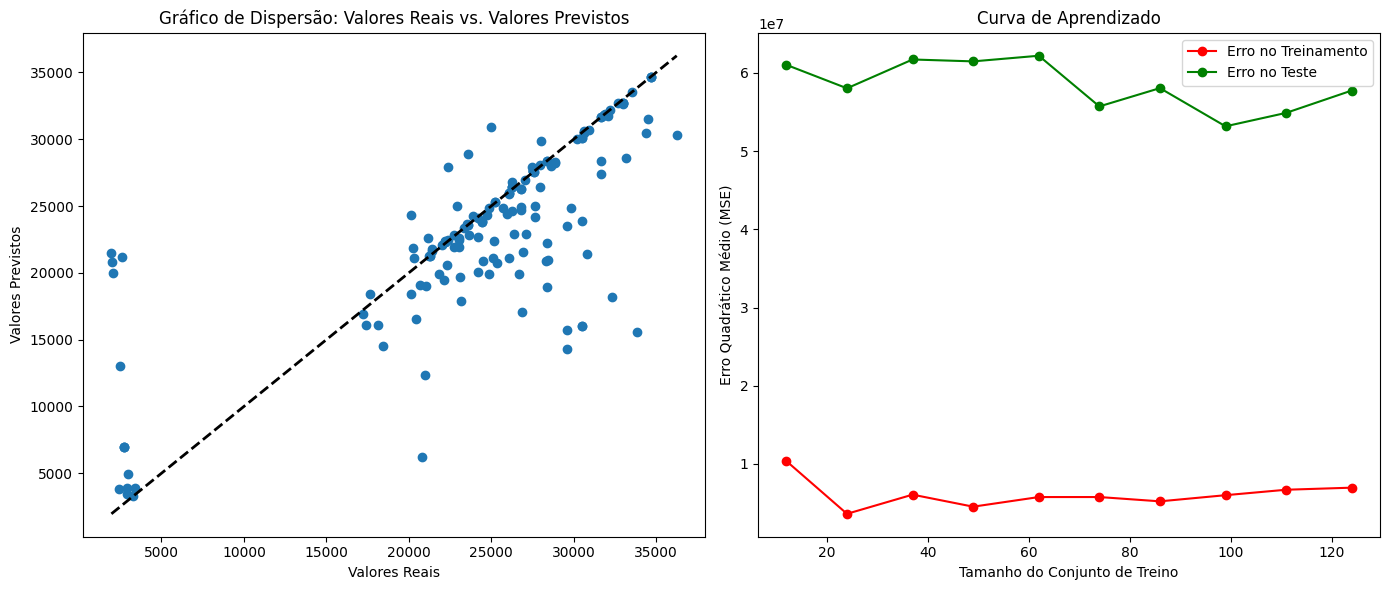

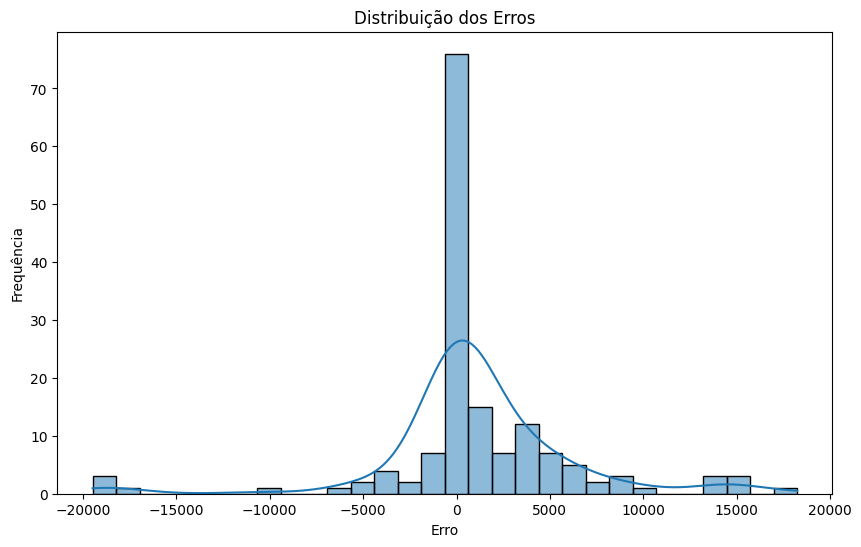

In [93]:
# Plotar os gráficos de acurácia e distribuição dos erros para o modelo Random Forest
plot_accuracy(rf_model, X_test, y_test, y_rf_pred)
plot_error_distribution(y_test, y_rf_pred)

## Treinamento do Modelo XGBoost

In [94]:
#df = pd.read_csv('data/data.csv', sep=';')
df = df.drop(columns=['date', 'holiday_name'], errors='ignore')
#df.head()

In [95]:
model, feature_columns = train_gradient_boosting(df)
# Fazer previsões no conjunto de teste
X = df.drop(columns=['beer_consumption_liters'])
y = df['beer_consumption_liters']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = model.predict(X_test)

Mean Squared Error: 27710793.821470834


## Acurácia e distribuição dos erros para o modelo XGBoost

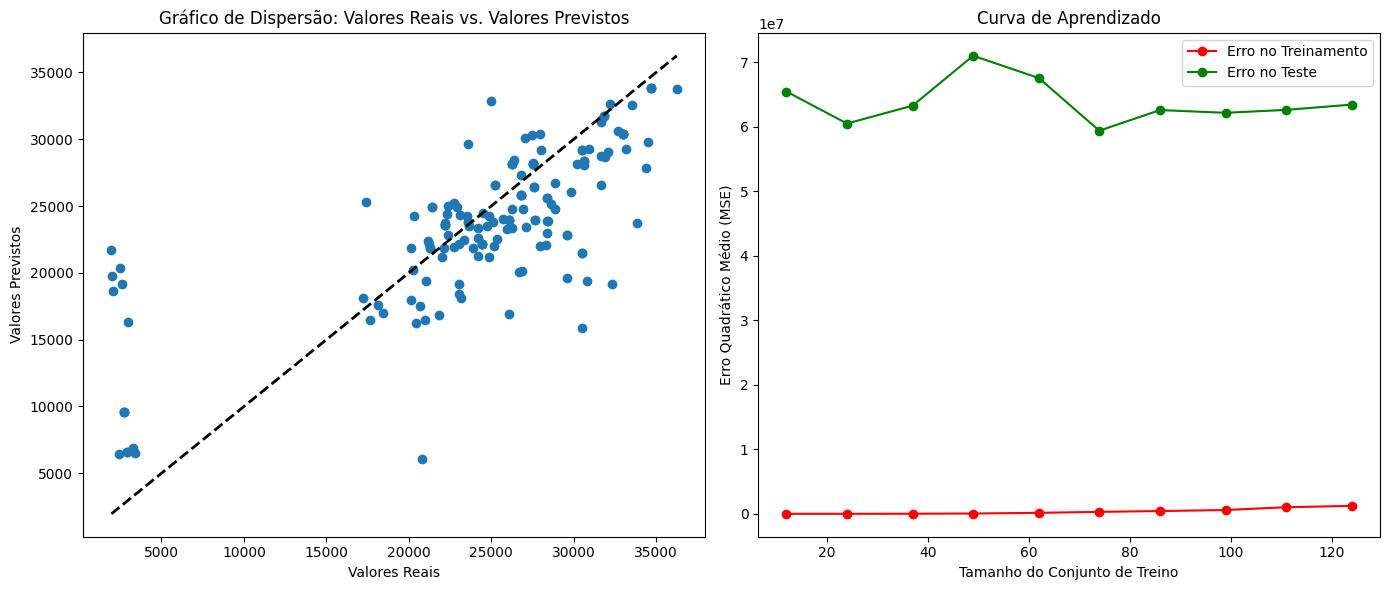

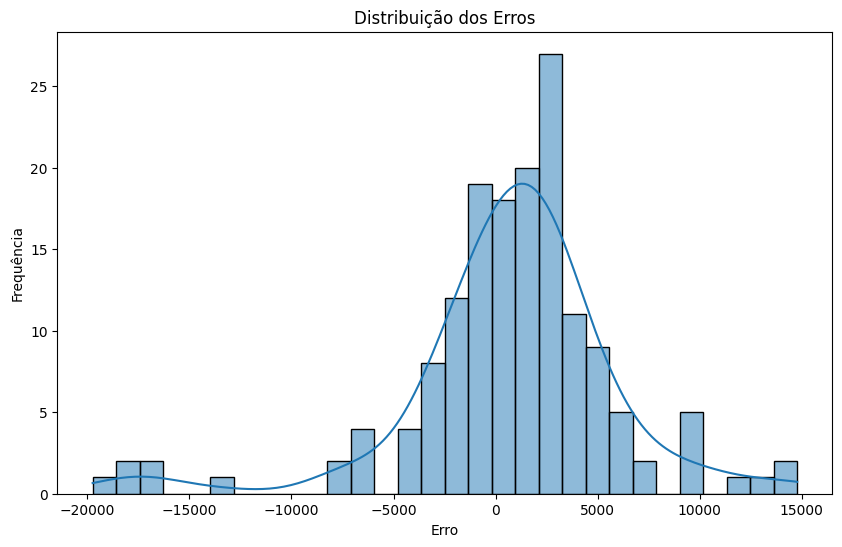

In [97]:
# Plotar os gráficos de acurácia e distribuição dos erros
plot_accuracy(model, X_test, y_test, y_pred)
plot_error_distribution(y_test, y_pred)

## Comparativo de predição entre Random Forest e XGBoost

In [98]:
new_data = pd.DataFrame({
    'avg_temperature_c': [30.0],
    'min_temperature_c': [25.0],
    'max_temperature_c': [35.0],
    'precipitation_mm': [10.0],
    'weekend': [1],
    'is_corinthians': [1],
    'is_sao_paulo': [0],
    'is_palmeiras': [0],
    'is_flamengo': [0],
    'is_vasco': [0],
    'is_cruzeiro': [0],
    'is_gremio': [0],
    'is_atletico_mineiro': [0],
    'is_bahia': [0],
    'is_internacional': [0],
    'is_holiday': [0],
    'is_city_match': [1],
    'month': [4]
})

### XGBoost

In [99]:
predicted_consumption = predict_beer_consumption_xg(model, feature_columns, new_data)
print(f'Predicted beer consumption: {predicted_consumption[0]} liters')

Predicted beer consumption: 6670.0326695356425 liters


### Random Forest

In [100]:
new_data = new_data.reindex(columns=rf_feature_columns, fill_value=0)
predicted_consumption = rf_model.predict(new_data)
print(f'Predicted beer consumption: {predicted_consumption[0]} liters')

Predicted beer consumption: 19606.5 liters


## Exemplo de Abordagem com Bayesian Network

In [102]:
# Converter colunas categóricas para strings
categorical_columns = ['weekend', 'is_holiday', 'has_match', 'match_type', 'is_flamengo', 'is_corinthians',
                       'is_sao_paulo', 'is_palmeiras', 'is_vasco', 'is_cruzeiro', 'is_gremio',
                       'is_atletico_mineiro', 'is_bahia', 'is_internacional', 'is_city_match']
df[categorical_columns] = df[categorical_columns].astype(str)

# Definir a estrutura da rede
model = BayesianNetwork([('avg_temperature_c', 'beer_consumption_liters'),
                         ('precipitation_mm', 'beer_consumption_liters'),
                         ('weekend', 'beer_consumption_liters'),
                         ('is_holiday', 'beer_consumption_liters'),
                         ('has_match', 'beer_consumption_liters'),
                         ('match_type', 'beer_consumption_liters'),
                         ('is_city_match', 'beer_consumption_liters')])

# Aprender os parâmetros da rede
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Fazer inferência na rede
infer = VariableElimination(model)

# Definir as evidências
evidence = {'avg_temperature_c': 27.3,
            'precipitation_mm': 0.0,
            'weekend': '0.0',
            'is_holiday': '1',
            'has_match': '0',
            'match_type': '0',
            'is_city_match': '0'}
# Calcular a distribuição posterior do consumo de cerveja
prediction = infer.map_query(variables=['beer_consumption_liters'], evidence=evidence)
print(prediction)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'beer_consumption_liters': np.float64(25461.0)}


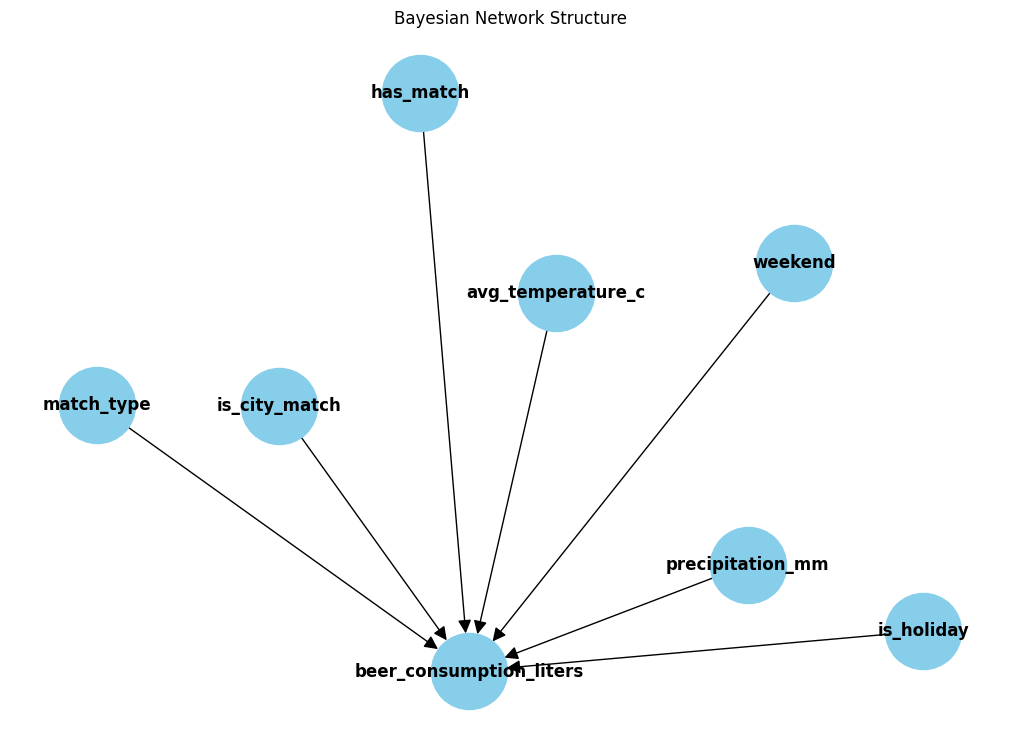

In [103]:
# Criar o gráfico usando networkx
G = nx.DiGraph()

# Adicionar nós e arestas ao gráfico
for edge in model.edges():
    G.add_edge(edge[0], edge[1])

# Desenhar o gráfico
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title('Bayesian Network Structure')
plt.show()